In [64]:
from random import randint
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, Input
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D
from tensorflow.keras.layers import BatchNormalization, Reshape, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model

from PIL import Image

seed = 123

## Tratamento, balanceamento e split de treino e teste de descritivos

In [3]:
# Caminhos dos  csvs:
treino_2018 ="/media/leandro/84EE-B5FB/isic_2018_treino.csv"
treino_2017 ="/media/leandro/84EE-B5FB/isic_2017_treino.csv"
teste = "/media/leandro/84EE-B5FB/isic_2017_teste.csv"
validacao = "/media/leandro/84EE-B5FB/isic_2017_validacao.csv"


In [4]:
# primeiramente, abrimos os descritivos dos dados de treino, a fim de analisar o balanceamento dos dados;
# julgamos válido ajustar a rede a um conjunto de dados balanceado, assim, evitando enviesar a rede

df_treino_2017 = pd.read_csv(treino_2017)
df_treino_2018 = pd.read_csv(treino_2018)

In [5]:
# analisando descritivo de treino de 2017
df_treino_2017.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


In [6]:
# ------- TREINO 2017

df_treino_2017['image_id'] = df_treino_2017['image_id'].apply(lambda x: x + '.jpg')
df_treino_2017['nevus'] = ((df_treino_2017['melanoma'] == 0) & 
                           (df_treino_2017['seborrheic_keratosis'] == 0)).astype(float)
df_treino_2017.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_treino_2017 = df_treino_2017.loc[(df_treino_2017['melanoma'] == 1) | (df_treino_2017['nevus'] == 1)]

# nesta célula, adicionamos extensões aos nomes dos arquivos, para que estes correspondam exatamente aos nomes
# que de fato seriam usados para acessar as imagens, por código, em seguida, precisávamos saber quais imagens
# eram casos de 'nevus', como esta flag não existe, inferimos que casos que não fossem 'melanoma', nem 
# 'seborrheic_keratosis' seriam 'nevus', à partir disso, criamos uma terceira flag, eliminamos a flag
# 'seborrheic_keratosis', que não nos convinha, por fim, mantivemos no dataframe, apenas as imagens
# que representassem ou casos de 'nevus' ou 'melanoma'

In [7]:
df_treino_2017.head()

,image_id,melanoma,nevus
0,ISIC_0000000.jpg,0.0,1.0
1,ISIC_0000001.jpg,0.0,1.0
2,ISIC_0000002.jpg,1.0,0.0
3,ISIC_0000003.jpg,0.0,1.0
4,ISIC_0000004.jpg,1.0,0.0


In [8]:
# partimos para o descritivo de treino de 2018

df_treino_2018.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# ------- TREINO 2018

df_treino_2018['image'] = df_treino_2018['image'].apply(lambda x: x + '.jpg')
df_treino_2018 = df_treino_2018.loc[(df_treino_2018['MEL'] == 1) | (df_treino_2018['NV'] == 1)]
df_treino_2018 = df_treino_2018[['image', 'MEL', 'NV']]
# nesta célula, apenas adicinamos as extensões aos nomes dos arquivos, filtramos imagens que representassem 
# casos de 'nevus' ou 'melanoma', por meio das flags 'NEV' e 'ML'

In [10]:
df_treino_2018.head()

,image,MEL,NV
0,ISIC_0024306.jpg,0.0,1.0
1,ISIC_0024307.jpg,0.0,1.0
2,ISIC_0024308.jpg,0.0,1.0
3,ISIC_0024309.jpg,0.0,1.0
4,ISIC_0024310.jpg,1.0,0.0


In [11]:
# aqui, unificamos os nomes das series dos descritivos, para que possam ser concatenados
df_treino_2018.columns = ['img', 'pos', 'neg']
df_treino_2017.columns = ['img', 'pos', 'neg']

In [12]:
# como podemos ver abaixo, as bases estão desbalanceadas

In [13]:
df_treino_2017['pos'].value_counts(1)

0.0    0.785796
1.0    0.214204
Name: pos, dtype: float64

In [14]:
df_treino_2018['pos'].value_counts(1)

0.0    0.857636
1.0    0.142364
Name: pos, dtype: float64

In [15]:
# nesta célula, juntamos as duas bases, como o intuito de obter um conjunto balanceado de dados

# separando casos positivos e negativos de cada ano
pos_2018 = df_treino_2018.loc[df_treino_2018['pos'] == 1]
pos_2017 = df_treino_2017.loc[df_treino_2017['pos'] == 1]

neg_2018 = df_treino_2018.loc[df_treino_2018['neg'] == 1]
neg_2017 = df_treino_2017.loc[df_treino_2017['neg'] == 1]

# juntando casos positivos e negativos de todos os anos
full_pos = pd.concat([pos_2017, pos_2018], axis = 0)
full_neg = pd.concat([neg_2017, neg_2018], axis = 0)

# amostrando aleatoriamente, n dados negativos, estes consistirão nas observações negativas (a amostragem
# é feita para separar um número de imagens equivalente ao número de imagens positivas que temos à disposição)
full_neg = full_neg.sample(n = full_pos.shape[0], random_state = seed)

full_pos = full_pos[['img', 'pos', 'neg']]
full_neg = full_neg[['img', 'pos', 'neg']]

filenames = pd.concat([full_pos, full_neg]).reset_index().drop('index', axis = 1)

filenames['pos'].value_counts()

0.0    1487
1.0    1487
Name: pos, dtype: int64

In [16]:
# com base no conjunto balanceado, obtemos splits de treino e teste
df_treino, df_teste = train_test_split(filenames, test_size = 0.2, random_state = seed)

In [17]:
# analisamos aqui, o descritivo de validação

df_valid = pd.read_csv(validacao)

In [18]:
df_valid.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [19]:
df_valid['image_id'] = df_valid['image_id'].apply(lambda x: x + '.jpg')
df_valid['nevus'] = ((df_valid['melanoma'] == 0) & 
                           (df_valid['seborrheic_keratosis'] == 0)).astype(float)
df_valid.drop('seborrheic_keratosis', axis = 1, inplace = True)
df_valid = df_valid.loc[(df_valid['melanoma'] == 1) | (df_valid['nevus'] == 1)]

df_valid.columns = ['img', 'pos', 'neg']
# para o tratamento do descritivo de validação, foi necessário adicionar extensões e criar a flag 'nevus', 
# de forma similar ao tratamento do descritivo de 2017, além disso, filtramos por apenas casos de 
# 'melanoma' ou 'nevus', também foram aplicados os mesmos nomes para as series 

In [20]:
df_valid.head()

,img,pos,neg
0,ISIC_0001769.jpg,0.0,1.0
1,ISIC_0001852.jpg,0.0,1.0
2,ISIC_0001871.jpg,0.0,1.0
3,ISIC_0003462.jpg,0.0,1.0
4,ISIC_0003539.jpg,0.0,1.0


In [21]:
# como podemos observar, a base de validação está desbalanceada

df_valid['pos'].value_counts(1)

0.0    0.722222
1.0    0.277778
Name: pos, dtype: float64

In [22]:
# para balanceá-la, elminaremos casos negativos o suficiente para que o número resultante se equipare 
# ao número de casos positivos

df_valid_pos = df_valid.loc[df_valid['pos'] == 1]
df_valid_neg = df_valid.loc[df_valid['neg'] == 1]

In [23]:
len(df_valid_pos), len(df_valid_neg)

# amostraremos 30 valores aleatórios dentre os casos negativos, e estes serão concatenados ao conjunto de
# casos positivos, o conjunto resultante consistirá no descritivo de validação

(30, 78)

In [24]:
df_valid_neg = df_valid_neg.sample(30, random_state = seed)
df_valid = pd.concat([df_valid_pos, df_valid_neg])

In [25]:
df_valid['pos'].value_counts(1)

0.0    0.5
1.0    0.5
Name: pos, dtype: float64

In [26]:
# descritivo de teste (cujas predições devemos entregar)

df_pred = pd.read_csv(teste)

In [27]:
df_pred.head()

,image_id
0,ISIC_0012086
1,ISIC_0012092
2,ISIC_0012095
3,ISIC_0012134
4,ISIC_0012136


In [28]:
df_pred['image_id'] = df_pred['image_id'].apply(lambda x: x + '.jpg')
df_pred.columns = ['img']

# para o tratamento do descritivo de teste, aplicamos extensões e unificamos nome da series

In [29]:
df_pred.head()

,img
0,ISIC_0012086.jpg
1,ISIC_0012092.jpg
2,ISIC_0012095.jpg
3,ISIC_0012134.jpg
4,ISIC_0012136.jpg


In [30]:
# ao final do processo, possuímos df_treino, df_teste, df_valid, df_pred

In [36]:
df_treino = df_treino.reset_index()
df_valid = df_valid.reset_index()
df_treino.drop('index', axis = 1, inplace = True)
df_valid.drop('index', axis = 1, inplace = True)

## Pré-processamento

In [37]:
# farei o pré processamento das imagens conforme estiver alimentando o ajuste da rede, este será realizado em 
# batches

In [38]:
# divisão dos dados de treino em batches

n_batches = 5
data = df_treino
batch_list = []

resto = data.shape[0] % n_batches
step = data.shape[0] // n_batches
count = 0
lower_idx = 0

for n in range(n_batches):
    
    upper_idx = lower_idx + step 
    
    exec(f'batch_{count} = data.iloc[{lower_idx}:{upper_idx}]')
    exec(f'batch_list.append(batch_{count})')
    
    count += 1
    lower_idx += step
    
# somando resto ao último batch
batch_list[-1] = pd.concat([batch_list[-1], df_treino[-4:]])

# agora temos a lista 'batch_list', esta possui cinco dataframes, cada um deles, contendo uma porção de 
# 'df_treino', carregaremos cada batch e ajustaremos a rede a cada um deles

In [39]:
diretorio_treino = "/media/leandro/84EE-B5FB/isic_treino_selecionadas/"
diretorio_teste ="/media/leandro/84EE-B5FB/isic_2017_teste/"
diretorio_val ="/media/leandro/84EE-B5FB/isic_2017_validacao/isic_2017_validacao/"

In [40]:
# ao carregarmos cada um dos batches, pré processaremos e faremos 'data augmentation', através de:

# carregamento
def get_images_n_labels(dataframe, path = diretorio_treino, 
                        series_name = 'img', label_name = 'pos', i = 50, j = 50):
    
    x = []
    y = []
    
    for n in range(dataframe.shape[0]):
        
        img = cv2.imread(path + dataframe[series_name].iloc[n])
        img = cv2.resize(img, (i, j))
        x.append(img)
        y.append(dataframe[label_name].iloc[n])
        
    return np.array(x), np.array(y)

# pré processamento

def segmentation(img):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations = 3)
    res = cv2.bitwise_and(img,img,mask = sure_bg)
    
    return res

def bgr_CLAHE(img):
    
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (6, 6))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return img

def img_preproc(img):
    
    img = bgr_CLAHE(segmentation(img))
    img = img / 255

    
    return img

# augmentation

def zoom(img, original_dim = [50, 50], h_slice = [5, 45], v_slice = [5, 45]):

    img = img[v_slice[0] : v_slice[1], h_slice[0] : h_slice[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img 

# horizontal shift
def h_shift(image, original_dim = [50, 50], shift = 5):
    
    T_x = shift
    T_y = 0
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[0 : original_dim[0], shift : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

# vertical shift
def v_shift(image, original_dim = [50, 50], shift = 5):
    
    T_x = 0
    T_y = shift
    
    M = np.array([[1, 0, T_x], [0, 1, T_y]], dtype = 'float32')
    img_transladada = cv2.warpAffine(image, M, (original_dim[0], original_dim[1]))
    img = img_transladada[shift : original_dim[0], 0 : original_dim[1]]
    img = cv2.resize(img, (original_dim[0], original_dim[1]))
    
    return img

def rotation_90(img):

    rows, cols, chnls = img.shape
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), 90, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    
    return img

def data_augmentation(x, y):
    
    augmentation_imgs = []
    augmentation_labels = []

    for n in range(len(x)):

        image = x[n]
        classe = y[n]
        augment = randint(0, 2) # booleano (33.3% de chance de aplicar augmentation)

        if augment == 1:
            process = randint(0, 5) # seleção aleatória do processo de augmentation

            if process == 0:
                image = cv2.flip(image, 0)
                augmentation_imgs.append(image) # horizontal flip
                augmentation_labels.append(classe)

            if process == 1:
                image = zoom(image)
                augmentation_imgs.append(image) # zoom 0.2
                augmentation_labels.append(classe)

            if process == 2:
                image = h_shift(image)
                augmentation_imgs.append(image) # horizontal shift
                augmentation_labels.append(classe)

            if process == 3:
                image = v_shift(image)
                augmentation_imgs.append(image) # vertical shift
                augmentation_labels.append(classe)

            if process == 4:
                image = rotation_90(image)
                augmentation_imgs.append(image) # rotaton 90°
                augmentation_labels.append(classe)
                
    return augmentation_imgs, augmentation_labels

# consolidando os processos acima em um função
def single_batch_prep(batch_df, width = 50, height = 50):
    
    x, y = get_images_n_labels(batch_df)

    # pré processamento de imagens
    x = [img_preproc(i) for i in x]

    # data augmentation
    augmentation_imgs, augmentation_labels = data_augmentation(x, y)
    
    return np.array(x + augmentation_imgs), np.array(list(y) + augmentation_labels)

In [41]:

px_h, px_v, chnls = 50, 50, 3
ipt_e = Input(shape = (px_h, px_v, chnls))

encoder = Conv2D(4, (3, 3), input_shape = (px_h, px_v, chnls), activation = 'relu', padding = 'same')(ipt_e)
encoder = MaxPool2D((5, 5))(encoder)
encoder = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(encoder)
encoder = MaxPool2D((2, 2))(encoder)
encoder = Conv2D(16, (2, 2), activation = 'relu', padding = 'same')(encoder)
encoder = Flatten()(encoder)
encoder = Dense(32, name = 'gargalo')(encoder)

decoder = Dense(400)(encoder)
decoder = Reshape(target_shape = (5, 5, 16))(decoder)
decoder = Conv2D(8, (2, 2), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(4, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = UpSampling2D((5, 5))(decoder)
decoder = Conv2D(4, (3, 3), activation = 'relu', padding = 'same')(decoder)
decoder = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(decoder)

autoencoder = Model(inputs = ipt_e, outputs = decoder, name = 'autoencoder')
autoencoder.compile(loss = 'mean_squared_error')

In [42]:
pickle.dump(batch_0, open('batch_0.pkl', 'wb'))
pickle.dump(batch_1, open('batch_1.pkl', 'wb'))
pickle.dump(batch_2, open('batch_2.pkl', 'wb'))
pickle.dump(batch_3, open('batch_3.pkl', 'wb'))
pickle.dump(batch_4, open('batch_4.pkl', 'wb'))

autoencoder.save('ae.h5')

In [43]:
x_valid, y_valid = get_images_n_labels(df_valid, path = diretorio_val)

In [44]:
# carregar batch para teste
x_0, y_0 = single_batch_prep(batch_0)

In [45]:
# escolhendo dimensões para resize

# dims = [cv2.imread(f'treino_full_non_preproc/{i}').shape 
#         for i in os.listdir('treino_full_non_preproc') if '.jpg' in i and i in df_treino['img'].tolist()]
# i = pd.Series([i[0] for i in dims])
# j = pd.Series([i[1] for i in dims])
# i.median(), j.median()

In [46]:
# neste notebook, são 5 batches ('batch_0' - 'batch_4')

In [47]:
# no ajuste de um batch, devemos carregar o df descritivo do batch, os dados de validação, o ae, 
# fazer o ajuste, salvar o ae

autoencoder = load_model('ae.h5')
batch = pickle.load(open('batch_0.pkl', 'rb'))

In [48]:
es = EarlyStopping(patience = 5, restore_best_weights = True)


In [59]:
# ajustando encoder ao primeiro batch
%timeit
autoencoder.fit(x_0, x_0, batch_size = 10, epochs = 2000, validation_data = (x_valid, x_valid), callbacks = [es])

Epoch 1/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0285 - val_loss: 23427.5938
Epoch 2/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0278 - val_loss: 23437.7480
Epoch 3/2000
61/61 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 23431.0293
Epoch 4/2000
61/61 [==============================] - 0s 3ms/step - loss: 0.0268 - val_loss: 23427.9023
Epoch 5/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 23440.7793
Epoch 6/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0258 - val_loss: 23423.7871
Epoch 7/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0254 - val_loss: 23433.1641
Epoch 8/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 23431.2246
Epoch 9/2000
61/61 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 23407.4336
Epoch 10/2000
61/61 [==============================] - 0s 4ms/st

In [50]:
x_treino_cod = autoencoder.predict(x_0)
x_valid_cod = autoencoder.predict(x_valid)

In [51]:
x_treino_cod.shape, x_valid_cod.shape

((603, 50, 50, 3), (60, 50, 50, 3))

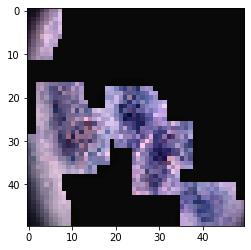

In [56]:
plt.imshow(x_0[0], cmap = 'gray')

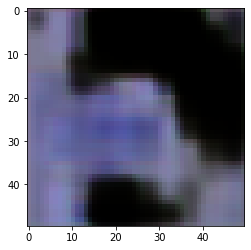

In [58]:
plt.imshow(x_treino_cod[0], cmap = 'gray')

# rede primaria

In [60]:
cnn_i, cnn_j, cnn_chnls = 50, 50, 3

cnn = Sequential()
cnn.add(Conv2D(50, (3, 3), input_shape = (cnn_i, cnn_j, cnn_chnls), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(MaxPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(AvgPool2D((2, 2)))
cnn.add(Conv2D(50, (3, 3), activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(AvgPool2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dropout(0.2))
cnn.add(Dense(25, activation = 'relu', kernel_regularizer = l2(0.05)))
cnn.add(Dense(1, activation = 'relu'))
        
cnn.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 0.001))

es = EarlyStopping(monitor = 'loss', patience = 5) 

In [61]:
batch_size = 100

# Rede com o encoder

In [62]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_treino_cod, y_0, 
             epochs = 100,
             validation_data = (x_valid_cod, y_valid),
             callbacks = [es])

Epoch 1/100
19/19 [==============================] - 7s 350ms/step - loss: 9.3587 - val_loss: 6.7322
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 8.2067 - val_loss: 6.2904
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 8.0985 - val_loss: 6.2674
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 7.2716 - val_loss: 5.3171
Epoch 5/100
19/19 [==============================] - 0s 16ms/step - loss: 6.5285 - val_loss: 5.2962
Epoch 6/100
19/19 [==============================] - 0s 17ms/step - loss: 6.1434 - val_loss: 4.9205
Epoch 7/100
19/19 [==============================] - 0s 17ms/step - loss: 6.1321 - val_loss: 4.8056
Epoch 8/100
19/19 [==============================] - 0s 17ms/step - loss: 5.4053 - val_loss: 4.4572
Epoch 9/100
19/19 [==============================] - 0s 16ms/step - loss: 5.1415 - val_loss: 4.2280
Epoch 10/100
19/19 [==============================] - 0s 16ms/step - loss: 4.6762 - val_loss: 4.128

In [63]:
y_treino_pred = cnn.predict(x_treino_cod)

In [65]:
roc_auc_score(y_0, y_treino_pred)

0.6938337624612135

# Rede sem o encoder

In [66]:
es = EarlyStopping(patience = 5, restore_best_weights = True)

cnn.fit(x_0, y_0, 
             epochs = 100,
             validation_data = (x_valid, y_valid),
             callbacks = [es])

Epoch 1/100
19/19 [==============================] - 0s 24ms/step - loss: 0.6763 - val_loss: 7.6455
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6889 - val_loss: 7.6445
Epoch 3/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6808 - val_loss: 7.6442
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6585 - val_loss: 7.6457
Epoch 5/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6914 - val_loss: 7.6461
Epoch 6/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6539 - val_loss: 7.5099
Epoch 7/100
19/19 [==============================] - 0s 17ms/step - loss: 0.6626 - val_loss: 7.7059
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6484 - val_loss: 7.1244
Epoch 9/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6342 - val_loss: 6.6903
Epoch 10/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6052 - val_loss: 7.3482

In [67]:
y_treino_pred = cnn.predict(x_0)

In [68]:
roc_auc_score(y_0, y_treino_pred)

0.8446116942848968